In [1]:
import os
import numpy as np
import sep
import seaborn 
import pandas as pd
from astropy.io import fits
from astropy.io import ascii
import matplotlib.pyplot as plt 

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
%matplotlib inline

In [3]:
data_path = os.path.abspath('/home/bos0109/sersic/work/rhino/data/extract_test/stellar/CSTAR/')

In [4]:
images_path = os.path.join(data_path, 'images')
master_Ryan = os.path.join(images_path, 'master10_wcs.fits')

In [5]:
mR = fits.getdata(master_Ryan)

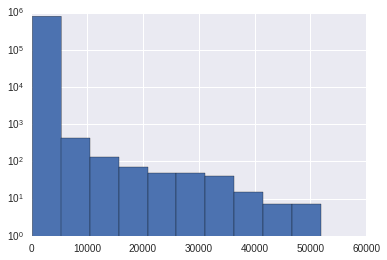

In [44]:
m2 = mR[mR > 0.]
plt.hist(m2.flatten(), log=True)

plt.show()

In [6]:
data = mR.byteswap().newbyteorder()

In [7]:
bkg = sep.Background(data)

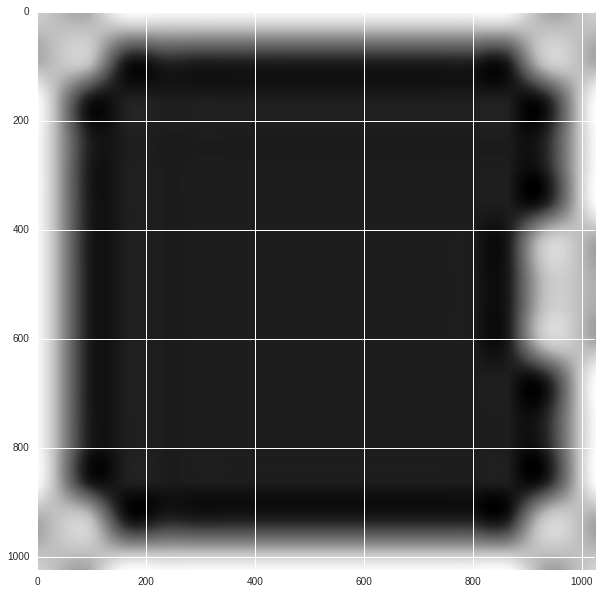

In [9]:
fig = plt.figure(figsize=(10,10))
plt.imshow(bkg.back())

In [10]:
img = data - bkg

In [48]:
thresh = 100.*bkg.globalrms
sources = sep.extract(img, thresh)

In [24]:
sep.extract?

In [49]:
obj = pd.DataFrame(sources)
print len(obj)

381


In [13]:
stars = os.path.join(data_path, 'cats/stars.dat') 
stars = ascii.read(stars, names= ['cstarid','x','y','imag'])
stars = stars.to_pandas()
stars['objID'] = range(len(stars))

In [21]:
len(stars)

10241

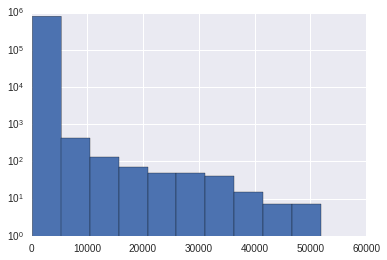

In [47]:
plt.hist(data[data > 0.].flatten(), log=True)
plt.show()

In [14]:
import astroML.crossmatch as cx

## Right

In [50]:
S = np.array([stars['x'], stars['y']]).T
O = np.array([obj['x'], obj['y']]).T

In [51]:
distr, indr  = cx.crossmatch(S, O, max_distance=2.)

In [52]:
matchsr = ~np.isinf(distr)

## Left

In [53]:
distl, indl  = cx.crossmatch(O, S, max_distance=2.)

In [54]:
matchsl = ~np.isinf(distl)

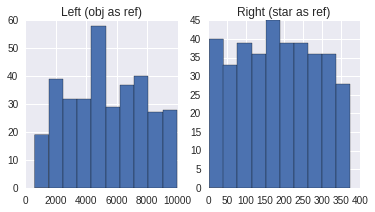

In [55]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.hist(indl[matchsl])
plt.title('Left (obj as ref)')
plt.subplot(122)
plt.hist(indr[matchsr])
plt.title('Right (star as ref)')
plt.show()

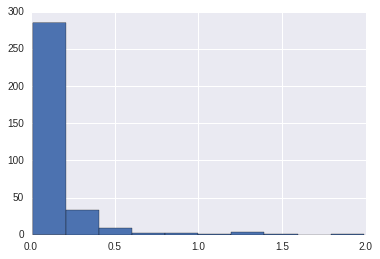

In [56]:
plt.hist(distl[matchsl].flatten())
plt.show()

Now the matchs are from left to **RIGHT**:
* matchs between the objects detected and stars in the catalog, using as reference *star catalog*.

right to **LEFT**
* matchs between stars in the catalog and objects using as reference *objects* detected

In [57]:
objID = np.zeros_like(O[:,0]) -1
CSTARID = np.zeros_like(O[:,0]) -1
for i in range(len(O)):
    if distl[i] != np.inf: 
        dist_o = distl[i]
        ind_o  = indl[i]
        # now ind is a star number
        # lets see if that star has matched the same obj
        if distr[ind_o] != np.inf:
            dist_s = distr[ind_o]
            ind_s = indr[ind_o]
            if ind_s == i:
                objID[i] = ind_o  
                CSTARID[i] = stars['cstarid'][ind_o]

In [58]:
obj['objID'] = objID
obj['cstarid'] = CSTARID

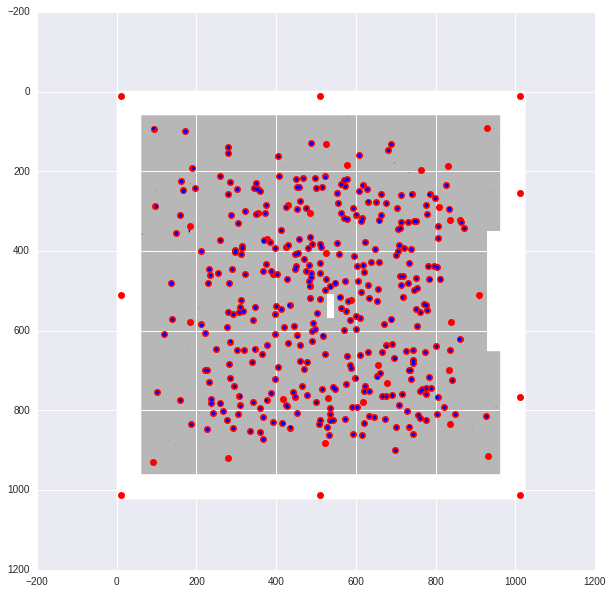

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(data)
f = obj['objID'] > 0
plt.plot(obj['x'], obj['y'], 'ro')
plt.plot(stars['x'][matchsr], stars['y'][matchsr], 'b.')

In [ ]:
fake = obj[~f]
count = 0

for index in range(len(fake)):
    i = int(fake.reset_index()['x'][index])
    j = int(fake.reset_index()['y'][index])
    plt.imshow(data[i-15:i+15, j-15:j+15], cmap=)
    plt.title('{}'.format(index))
    #plt.plot(stars['x'], stars['y'], '.b')
    plt.xlim(i-15,i+15)
    plt.ylim(j-15,j+15)
    #plt.savefig('stamp_{}_{}.png'.format(i,j))
    #plt.close()
    if index > 4 : break

In [44]:
print sum(objID > 0.), sum(objID < 0.)

341 40
